<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_TSLA_Rolling_Linear_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [18]:
pip install yfinance

In [19]:
pip install yahoofinancials

In [20]:
pip install pyfinance

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

# Data

In [22]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "TSLA",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close
1759,2020-12-31 11:30:00-05:00,715.479980,718.719971,711.679993,715.159973,715.159973,6814139,715.289978
1760,2020-12-31 12:30:00-05:00,715.090698,717.320007,712.659973,715.289978,715.289978,3831598,708.299988
1761,2020-12-31 13:30:00-05:00,715.280029,717.770020,707.250000,708.299988,708.299988,4788232,698.000000
1762,2020-12-31 14:30:00-05:00,708.306580,710.869873,698.000000,698.000000,698.000000,7320384,705.210022
1763,2020-12-31 15:30:00-05:00,698.203186,706.899902,697.690002,705.210022,705.210022,4105876,NaN


In [23]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [24]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Datetime,,,,,,,,,,
2020-01-02 09:30:00-05:00,84.900002,85.573997,84.391998,84.780998,84.780998,3205151,85.218002,84.780998,84.780998,0.0
2020-01-02 10:30:00-05:00,84.784004,85.329498,84.524002,85.218002,85.218002,958142,85.264000,84.999500,84.824699,958142.0
2020-01-02 11:30:00-05:00,85.229996,85.452003,85.057999,85.264000,85.264000,950558,85.951881,85.087667,84.868629,1908700.0
2020-01-02 12:30:00-05:00,85.271996,85.970001,85.212578,85.951881,85.951881,1173352,86.078995,85.477961,84.976954,3082052.0
2020-01-02 13:30:00-05:00,85.955246,86.139145,85.620003,86.078995,86.078995,1246023,85.960098,85.764959,85.087158,4328075.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 11:30:00-05:00,715.479980,718.719971,711.679993,715.159973,715.159973,6814139,715.289978,710.821655,685.041745,664602988.0
2020-12-31 12:30:00-05:00,715.090698,717.320007,712.659973,715.289978,715.289978,3831598,708.299988,715.293315,688.066568,668434586.0
2020-12-31 13:30:00-05:00,715.280029,717.770020,707.250000,708.299988,708.299988,4788232,698.000000,712.916646,690.089910,663646354.0


In [25]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [26]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [27]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end  subperiod           
129  0           0.022466
     1           0.023400
     2           0.023607
     3           0.024645
     4           0.024892
...                   ...
1762 1758        1.003359
     1759        0.995239
     1760        0.995955
     1761        0.987473
     1762        0.970056

[212420 rows x 1 columns]

In [28]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred

,subperiod,end,predicted
0,0,129,0.022466
1,1,259,0.023389
2,2,390,0.023622
3,3,522,0.024627
4,4,655,0.024872
...,...,...,...
1758,1758,8800,1.003943
1759,1759,7042,0.995612
1760,1760,5283,0.995944
1761,1761,3523,0.986981


In [29]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.022529
1,1,0.022600
2,2,0.023667
3,3,0.023864
4,4,0.023680
...,...,...
1758,1758,0.999581
1759,1759,0.999783
1760,1760,0.988941
1761,1761,0.972966


In [30]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod','end'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['TSLA_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,TSLA_RMSE_LIN
0,0.022529,0.022466,0.000063,3.955640e-09,0.000063
1,0.022600,0.023389,-0.000789,6.220478e-07,0.000789
2,0.023667,0.023622,0.000045,2.024096e-09,0.000045
3,0.023864,0.024627,-0.000762,5.813791e-07,0.000762
4,0.023680,0.024872,-0.001192,1.420024e-06,0.001192
...,...,...,...,...,...
1758,0.999581,1.003943,-0.004362,1.902894e-05,0.004362
1759,0.999783,0.995612,0.004171,1.739915e-05,0.004171
1760,0.988941,0.995944,-0.007003,4.904253e-05,0.007003
1761,0.972966,0.986981,-0.014015,1.964301e-04,0.014015


In [31]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.007792144032741915

## With sentiment

In [32]:
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df['date'].map(str) + '.' + df['datehour'].map(str) 
df['hour_id']

0        2020-01-02.9
1       2020-01-02.10
2       2020-01-02.11
3       2020-01-02.12
4       2020-01-02.13
            ...      
1759    2020-12-31.11
1760    2020-12-31.12
1761    2020-12-31.13
1762    2020-12-31.14
1763    2020-12-31.15
Name: hour_id, Length: 1764, dtype: object

In [33]:
sent = pd.read_csv('TSLA_sentiment_hr.csv')
df = pd.merge(df, sent, on = 'hour_id', how = 'left')
df = df.fillna(0)

In [34]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=130)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)
y_pred_sent

,subperiod,predicted
0,0,0.022478
1,1,0.023510
2,2,0.023634
3,3,0.024435
4,4,0.025226
...,...,...
212415,1758,1.001132
212416,1759,0.995337
212417,1760,0.996116
212418,1761,0.987628


In [35]:
rolling.predicted

end   subperiod
129   0            0.022478
      1            0.023510
      2            0.023634
      3            0.024435
      4            0.025226
                     ...   
1762  1758         1.001132
      1759         0.995337
      1760         0.996116
      1761         0.987628
      1762         0.969439
Name: predicted, Length: 212420, dtype: float64

In [36]:
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [37]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})
linear_sent

,period,actual,predicted,predicted_sent
0,0,0.022529,0.022478,0.022478
1,1,0.022600,0.046998,0.023499
2,2,0.023667,0.070955,0.023652
3,3,0.023864,0.097666,0.024416
4,4,0.023680,0.126106,0.025221
...,...,...,...,...
1758,1758,0.999581,5.008150,1.001630
1759,1759,0.999783,3.982856,0.995714
1760,1760,0.988941,2.988284,0.996095
1761,1761,0.972966,1.974231,0.987116


In [38]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['TSLA_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])
linear_sent

,period,actual,predicted_sent,difference_sent,sq_er_sent,TSLA_RMSE_LIN_SENTIMENT
0,0,0.022529,0.022478,0.000051,2.568354e-09,0.000051
1,1,0.022600,0.023499,-0.000899,8.076799e-07,0.000899
2,2,0.023667,0.023652,0.000016,2.444708e-10,0.000016
3,3,0.023864,0.024416,-0.000552,3.046364e-07,0.000552
4,4,0.023680,0.025221,-0.001541,2.374909e-06,0.001541
...,...,...,...,...,...,...
1758,1758,0.999581,1.001630,-0.002049,4.197853e-06,0.002049
1759,1759,0.999783,0.995714,0.004069,1.655528e-05,0.004069
1760,1760,0.988941,0.996095,-0.007153,5.117206e-05,0.007153
1761,1761,0.972966,0.987116,-0.014150,2.002181e-04,0.014150


In [39]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.007765116683198777

In [40]:
TSLA_linear = pd.merge(linear, linear_sent, on = 'actual')
TSLA_linear

,actual,predicted,difference,sq_er,TSLA_RMSE_LIN,period,predicted_sent,difference_sent,sq_er_sent,TSLA_RMSE_LIN_SENTIMENT
0,0.022529,0.022466,0.000063,3.955640e-09,0.000063,0,0.022478,0.000051,2.568354e-09,0.000051
1,0.022600,0.023389,-0.000789,6.220478e-07,0.000789,1,0.023499,-0.000899,8.076799e-07,0.000899
2,0.023667,0.023622,0.000045,2.024096e-09,0.000045,2,0.023652,0.000016,2.444708e-10,0.000016
3,0.023864,0.024627,-0.000762,5.813791e-07,0.000762,3,0.024416,-0.000552,3.046364e-07,0.000552
4,0.023680,0.024872,-0.001192,1.420024e-06,0.001192,4,0.025221,-0.001541,2.374909e-06,0.001541
...,...,...,...,...,...,...,...,...,...,...
1780,0.999581,1.003943,-0.004362,1.902894e-05,0.004362,1758,1.001630,-0.002049,4.197853e-06,0.002049
1781,0.999783,0.995612,0.004171,1.739915e-05,0.004171,1759,0.995714,0.004069,1.655528e-05,0.004069
1782,0.988941,0.995944,-0.007003,4.904253e-05,0.007003,1760,0.996095,-0.007153,5.117206e-05,0.007153
1783,0.972966,0.986981,-0.014015,1.964301e-04,0.014015,1761,0.987116,-0.014150,2.002181e-04,0.014150


In [41]:
TSLA_linear.describe()

,actual,predicted,difference,sq_er,TSLA_RMSE_LIN,period,predicted_sent,difference_sent,sq_er_sent,TSLA_RMSE_LIN_SENTIMENT
count,1785.000000,1785.000000,1785.000000,1.785000e+03,1.785000e+03,1785.000000,1785.000000,1785.000000,1.785000e+03,1785.000000
mean,0.338792,0.338728,0.000065,6.314653e-05,4.596174e-03,883.072269,0.338725,0.000067,6.283779e-05,0.004576
std,0.258934,0.258706,0.007948,2.566043e-04,6.484233e-03,509.308073,0.258703,0.007929,2.557648e-04,0.006475
min,0.000000,0.001236,-0.080167,5.650952e-13,7.517281e-07,0.000000,0.001033,-0.079303,3.906775e-12,0.000002
25%,0.122614,0.122744,-0.002641,1.160927e-06,1.077463e-03,442.000000,0.122759,-0.002613,1.100081e-06,0.001049
50%,0.265260,0.265562,-0.000362,5.859847e-06,2.420712e-03,884.000000,0.265613,-0.000353,5.919967e-06,0.002433
75%,0.544626,0.544422,0.002213,2.932372e-05,5.415138e-03,1327.000000,0.544234,0.002263,2.959728e-05,0.005440
max,1.000000,1.003943,0.057337,6.426769e-03,8.016713e-02,1762.000000,1.001630,0.057222,6.288987e-03,0.079303


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

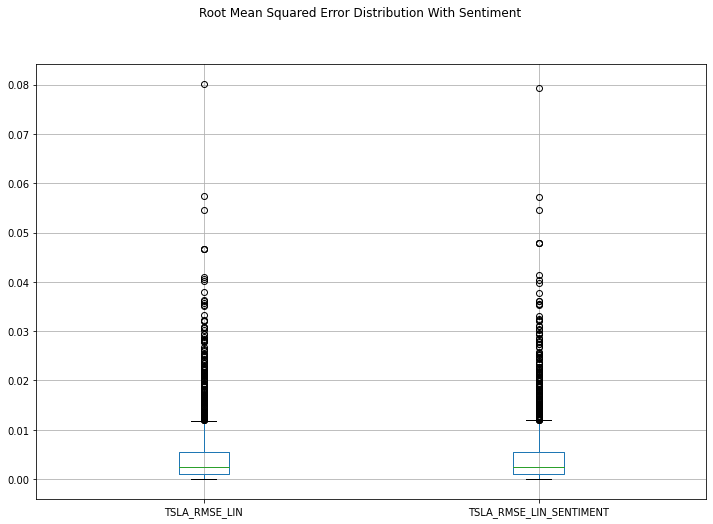

In [42]:
boxplot = TSLA_linear.boxplot(column=['TSLA_RMSE_LIN', 'TSLA_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [43]:
TSLA_linear_RMSE = TSLA_linear[['TSLA_RMSE_LIN', 'TSLA_RMSE_LIN_SENTIMENT']]
TSLA_linear_RMSE.describe()

,TSLA_RMSE_LIN,TSLA_RMSE_LIN_SENTIMENT
count,1.785000e+03,1785.000000
mean,4.596174e-03,0.004576
std,6.484233e-03,0.006475
min,7.517281e-07,0.000002
25%,1.077463e-03,0.001049
50%,2.420712e-03,0.002433
75%,5.415138e-03,0.005440
max,8.016713e-02,0.079303


In [44]:
TSLA_linear_RMSE.to_csv('TSLA_Linear_Comms_Results.csv')